# **Regresi UTS Telkom**

In [37]:
# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings

# Import dari scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)

# Import dari TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Import dari PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Pengaturan
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)


In [39]:
# 1. Muat data dari Google Drive
url = 'https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU'
output = 'KlasifikasiUTS.csv'
gdown.download(url, output, quiet=False)
df = pd.read_csv(output)

# 2. Pembersihan data dasar
df = df.drop_duplicates()
df = df.dropna()

# 3. Asumsi: Kolom target adalah kolom terakhir
target_col = df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

# Cek jumlah kelas dan distribusinya
n_classes = y.nunique()
print(f"Tugas ini adalah klasifikasi dengan {n_classes} kelas.")
print("\nDistribusi kelas pada target:")
print(y.value_counts())

# 4. Split dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y) # stratify untuk menjaga proporsi kelas

Downloading...
From (original): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=9fcf8ac2-b0f4-4b55-a353-f4c3fc35084e
To: /content/KlasifikasiUTS.csv
100%|██████████| 151M/151M [00:00<00:00, 156MB/s]


Tugas ini adalah klasifikasi dengan 2 kelas.

Distribusi kelas pada target:
Class
0    283253
1       473
Name: count, dtype: int64


In [40]:
# Identifikasi fitur kategorikal dan numerikal
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['number']).columns

# Buat pipeline preprocessing untuk fitur X
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

# Terapkan pipeline ke data latih dan uji
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Ubah label y menjadi format one-hot encoding
# Misal: 3 kelas -> label '2' menjadi [0, 0, 1]
y_train_encoded = to_categorical(y_train, num_classes=n_classes)
y_test_encoded = to_categorical(y_test, num_classes=n_classes)


print("Pra-pemrosesan selesai.")
print(f"Bentuk X_train setelah diproses: {X_train_proc.shape}")
print(f"Bentuk y_train setelah di-encode: {y_train_encoded.shape}")

Pra-pemrosesan selesai.
Bentuk X_train setelah diproses: (226980, 30)
Bentuk y_train setelah di-encode: (226980, 2)


In [42]:
def build_tf_classifier(input_shape, num_classes):
    """Membangun model MLP TensorFlow untuk klasifikasi."""
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        # --- PERUBAHAN PENTING ---
        # Layer output disesuaikan untuk klasifikasi multi-kelas
        layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model dengan loss dan metrik untuk klasifikasi
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy', # Loss untuk klasifikasi
        metrics=['accuracy'] # Metrik untuk klasifikasi
    )
    return model

# Bangun model
model_tf = build_tf_classifier(X_train_proc.shape[1], n_classes)
model_tf.summary()

# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Latih model
history_tf = model_tf.fit(
    X_train_proc, y_train_encoded,
    validation_split=0.2,
    epochs=50, # Epochs dikurangi agar cepat
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=2
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,122 (51.26 KB)

 Trainable params: 12,738 (49.76 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
5675/5675 - 18s - 3ms/step - accuracy: 0.9905 - loss: 0.0330 - val_accuracy: 0.9995 - val_loss: 0.0113 - learning_rate: 1.0000e-03
Epoch 2/50
5675/5675 - 15s - 3ms/step - accuracy: 0.9993 - loss: 0.0069 - val_accuracy: 0.9995 - val_loss: 0.0083 - learning_rate: 1.0000e-03
Epoch 3/50
5675/5675 - 23s - 4ms/step - accuracy: 0.9992 - loss: 0.0056 - val_accuracy: 0.9995 - val_loss: 0.0068 - learning_rate: 1.0000e-03
Epoch 4/50
5675/5675 - 17s - 3ms/step - accuracy: 0.9992 - loss: 0.0051 - val_accuracy: 0.9995 - val_loss: 0.0076 - learning_rate: 1.0000e-03
Epoch 5/50
5675/5675 - 25s - 4ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.9993 - val_loss: 0.0081 - learning_rate: 1.0000e-03
Epoch 6/50
5675/5675 - 35s - 6ms/step - accuracy: 0.9993 - loss: 0.0046 - val_accuracy: 0.9994 - val_loss: 0.0073 - learning_rate: 1.0000e-03
Epoch 7/50
5675/5675 - 20s - 4ms/step - accuracy: 0.9993 - loss: 0.0047 - val_accuracy: 0.9995 - val_loss: 0.0072 - learning_rate: 1.0000e-03
Epoch 

In [43]:
class ClassifierMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            # --- PERUBAHAN PENTING ---
            nn.Linear(64, num_classes) # Tidak perlu softmax, karena CrossEntropyLoss sudah include
        )

    def forward(self, x):
        return self.net(x)

# Persiapan data untuk PyTorch
# CrossEntropyLoss di PyTorch lebih suka target dalam bentuk integer, bukan one-hot
train_ds = TensorDataset(torch.tensor(X_train_proc, dtype=torch.float32),
                         torch.tensor(y_train.values, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = TensorDataset(torch.tensor(X_test_proc, dtype=torch.float32),
                        torch.tensor(y_test.values, dtype=torch.long))
test_loader = DataLoader(test_ds, batch_size=64)


# Inisialisasi model, loss, dan optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pt = ClassifierMLP(X_train_proc.shape[1], n_classes).to(device)
criterion = nn.CrossEntropyLoss() # Loss untuk klasifikasi
optimizer = torch.optim.Adam(model_pt.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    model_pt.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model_pt(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Pelatihan PyTorch Selesai.")

Pelatihan PyTorch Selesai.


1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
--- Laporan Klasifikasi TensorFlow ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.77      0.82        95

    accuracy                           1.00     56746
   macro avg       0.93      0.88      0.91     56746
weighted avg       1.00      1.00      1.00     56746


--- Laporan Klasifikasi PyTorch ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.89      0.75      0.81        95

    accuracy                           1.00     56746
   macro avg       0.94      0.87      0.91     56746
weighted avg       1.00      1.00      1.00     56746



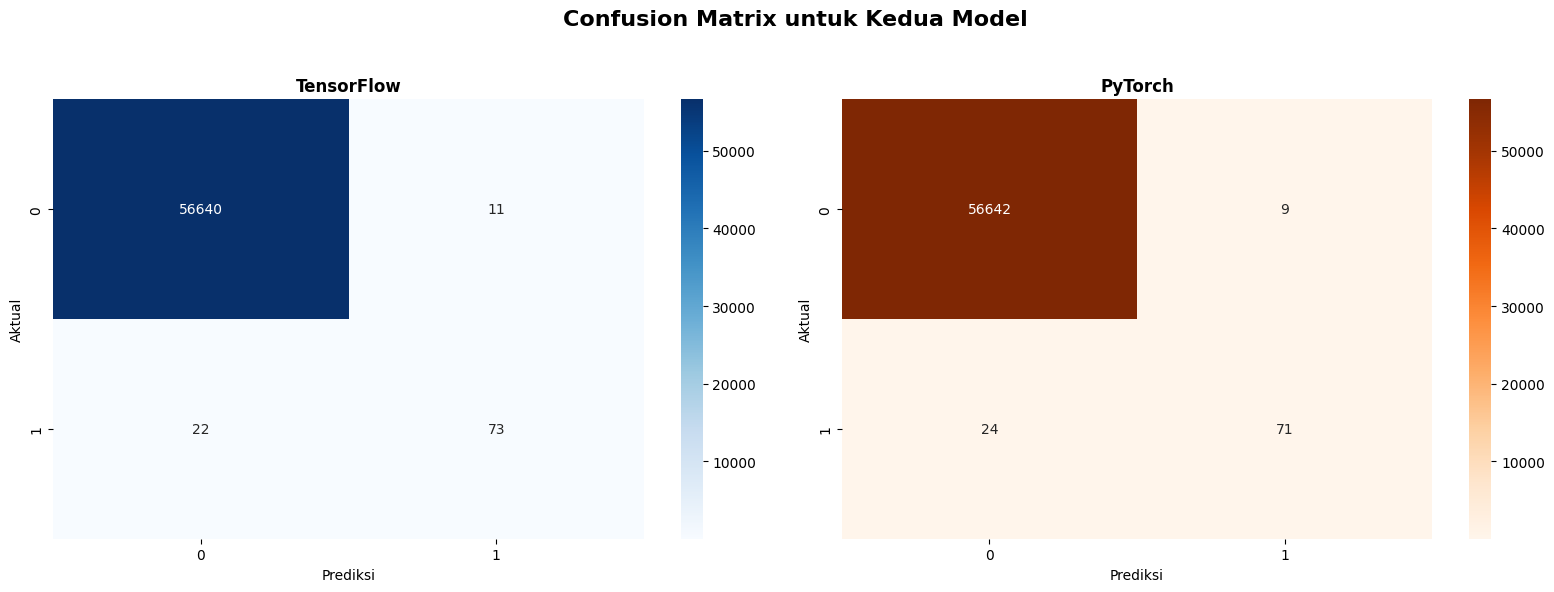

In [44]:
# --- Evaluasi TensorFlow ---
y_pred_proba_tf = model_tf.predict(X_test_proc)
y_pred_tf = np.argmax(y_pred_proba_tf, axis=1)

print("--- Laporan Klasifikasi TensorFlow ---")
print(classification_report(y_test, y_pred_tf))

# --- Evaluasi PyTorch ---
model_pt.eval()
y_pred_pt_list = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model_pt(xb)
        y_pred_pt_list.append(torch.argmax(preds, dim=1).cpu())
y_pred_pt = torch.cat(y_pred_pt_list).numpy()

print("\n--- Laporan Klasifikasi PyTorch ---")
print(classification_report(y_test, y_pred_pt))


# --- Visualisasi Confusion Matrix ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Confusion Matrix untuk Kedua Model', fontsize=16, fontweight='bold')

# Confusion Matrix TensorFlow
cm_tf = confusion_matrix(y_test, y_pred_tf)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('TensorFlow', fontweight='bold')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

# Confusion Matrix PyTorch
cm_pt = confusion_matrix(y_test, y_pred_pt)
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('PyTorch', fontweight='bold')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#**Penjelasan Teori**

1. Pre Processing:
  * Cleaning Missing Values
  * Normalise numerical feature with StandardScaler
  * Encode categorical feature with One-Hot Encoding

2. Multilayer Perceptron
  * TensorFlow
  * PyTorch

3. Evaluate
  * MSE = Mean Squared Error
  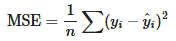
  * RMSE = Root Mean Squared Error
  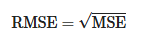
  * R2 Score = Coeficient Determination
  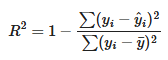

4. Visualisation

5. Conclusion
  * MLP Deep Learning is efective on non-linear learning
  * The use of Regularisation, Dropout, and BatchNorm helps reduce overfitting
  * TensorFlow and PyTorch are performing similarly